# Clip WorldCover to AOI
## Cut WorldCover tile to your Area of Interest

This notebook clips a large WorldCover tile to your specific AOI using a GeoJSON file.

## 1. Import Libraries

In [15]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

In [16]:
# Input paths
WORLDCOVER_FILE = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Artem/London_WC.tif"
GEOJSON_FILE = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/aois_json/London.geojson"

# Output path
OUTPUT_DIR = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "London_WorldCover_clipped.tif")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Input WorldCover: {WORLDCOVER_FILE}")
print(f"  Input GeoJSON: {GEOJSON_FILE}")
print(f"  Output file: {OUTPUT_FILE}")

Configuration:
  Input WorldCover: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Artem/London_WC.tif
  Input GeoJSON: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/aois_json/London.geojson
  Output file: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped.tif


## 3. Load and Inspect Input Files

In [17]:
print("="*70)
print("LOADING INPUT FILES")
print("="*70)

# Check if files exist
if not os.path.exists(WORLDCOVER_FILE):
    raise FileNotFoundError(f"WorldCover file not found: {WORLDCOVER_FILE}")
if not os.path.exists(GEOJSON_FILE):
    raise FileNotFoundError(f"GeoJSON file not found: {GEOJSON_FILE}")

# Load WorldCover metadata
print("\nWorldCover Tile:")
with rasterio.open(WORLDCOVER_FILE) as src:
    print(f"  Dimensions: {src.height} x {src.width} pixels")
    print(f"  Bands: {src.count}")
    print(f"  CRS: {src.crs}")
    print(f"  Bounds: {src.bounds}")
    print(f"  Resolution: {src.res[0]:.2f} m")
    worldcover_crs = src.crs

# Load GeoJSON (AOI)
print("\nGeoJSON (AOI):")
aoi = gpd.read_file(GEOJSON_FILE)

# Ensure AOI is in WGS84
if aoi.crs is None:
    aoi.set_crs("EPSG:4326", inplace=True)
    print("  ⚠ No CRS found, set to EPSG:4326")

if aoi.crs.to_epsg() != 4326:
    aoi = aoi.to_crs("EPSG:4326")
    print(f"  ⚠ Reprojected to EPSG:4326")

print(f"  CRS: {aoi.crs}")
print(f"  Bounds: {aoi.total_bounds}")
print(f"  Features: {len(aoi)}")

print("\n✓ Input files loaded successfully")
print("="*70)

LOADING INPUT FILES

WorldCover Tile:
  Dimensions: 36000 x 36000 pixels
  Bands: 1
  CRS: EPSG:4326
  Bounds: BoundingBox(left=-3.0, bottom=51.0, right=0.0, top=54.0)
  Resolution: 0.00 m

GeoJSON (AOI):
  CRS: EPSG:4326
  Bounds: [-0.16586871 51.48350222 -0.0892943  51.53128758]
  Features: 1

✓ Input files loaded successfully


## 4. Clip WorldCover to AOI

In [18]:
print("\n" + "="*70)
print("CLIPPING WORLDCOVER TO AOI")
print("="*70)

# Get geometries from GeoJSON
geometries = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]

print(f"\nClipping to {len(geometries)} geometry/geometries...")

# Open WorldCover and clip
with rasterio.open(WORLDCOVER_FILE) as src:
    # Clip to AOI
    out_image, out_transform = mask(src, geometries, crop=True, all_touched=True)
    out_meta = src.meta.copy()
    
    # Update metadata
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw"
    })
    
    print(f"\nClipped dimensions: {out_image.shape[1]} x {out_image.shape[2]} pixels")
    
    # Save clipped result
    with rasterio.open(OUTPUT_FILE, "w", **out_meta) as dest:
        dest.write(out_image)

print(f"\n✓ Clipped WorldCover saved: {OUTPUT_FILE}")
print(f"  File size: {os.path.getsize(OUTPUT_FILE) / (1024**2):.2f} MB")
print("="*70)


CLIPPING WORLDCOVER TO AOI

Clipping to 1 geometry/geometries...

Clipped dimensions: 574 x 920 pixels

✓ Clipped WorldCover saved: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped.tif
  File size: 0.04 MB


## 5. Analyze Clipped WorldCover

In [19]:
print("\n" + "="*70)
print("WORLDCOVER ANALYSIS")
print("="*70)

# WorldCover class names
class_names = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/sparse vegetation",
    70: "Snow and ice",
    80: "Permanent water bodies",
    90: "Herbaceous wetland",
    95: "Mangroves",
    100: "Moss and lichen"
}

# Load clipped data
with rasterio.open(OUTPUT_FILE) as src:
    data = src.read(1)

total_pixels = data.size
unique_classes, counts = np.unique(data, return_counts=True)

print("\nLand Cover Distribution:")
print("-" * 70)
print(f"{'Class':<6} {'Description':<30} {'Pixels':>12} {'Percentage':>10}")
print("-" * 70)

green_pixels = 0
green_classes = [10, 20, 30, 95]

for class_value, count in zip(unique_classes, counts):
    percentage = (count / total_pixels) * 100
    class_desc = class_names.get(class_value, f"Unknown")
    is_green = "✓" if class_value in green_classes else " "
    
    print(f"{class_value:<6} {class_desc:<30} {count:>12,} {percentage:>9.2f}% {is_green}")
    
    if class_value in green_classes:
        green_pixels += count

print("-" * 70)
print(f"{'TOTAL':<6} {'Green (10,20,30,95)':<30} {green_pixels:>12,} {100*green_pixels/total_pixels:>9.2f}%")
print(f"{'TOTAL':<6} {'Non-Green':<30} {total_pixels-green_pixels:>12,} {100*(total_pixels-green_pixels)/total_pixels:>9.2f}%")
print("="*70)

print("\n✓ Green classes (10, 20, 30, 95) will be used for ML training")


WORLDCOVER ANALYSIS

Land Cover Distribution:
----------------------------------------------------------------------
Class  Description                          Pixels Percentage
----------------------------------------------------------------------
0      Unknown                              37,990      7.19%  
10     Tree cover                           89,696     16.99% ✓
30     Grassland                            12,618      2.39% ✓
40     Cropland                                139      0.03%  
50     Built-up                            363,344     68.80%  
60     Bare/sparse vegetation                  375      0.07%  
80     Permanent water bodies               23,918      4.53%  
----------------------------------------------------------------------
TOTAL  Green (10,20,30,95)                 102,314     19.37%
TOTAL  Non-Green                           425,766     80.63%

✓ Green classes (10, 20, 30, 95) will be used for ML training


## 6. Visualize Clipped WorldCover

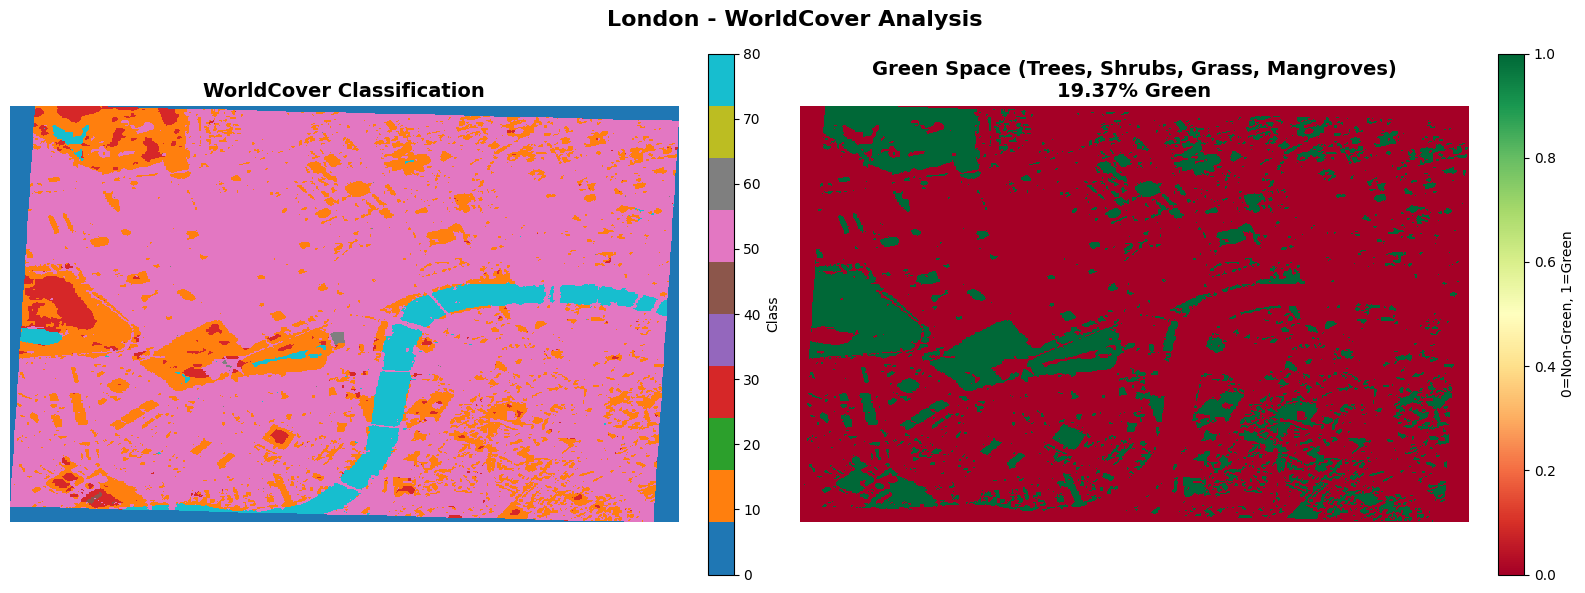


✓ Visualization saved: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped_visualization.png


In [20]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Full classification
im1 = axes[0].imshow(data, cmap='tab10', interpolation='nearest')
axes[0].set_title('WorldCover Classification', fontsize=14, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='Class')

# 2. Binary green/non-green
green_mask = np.isin(data, green_classes).astype(np.uint8)
im2 = axes[1].imshow(green_mask, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
axes[1].set_title(f'Green Space (Trees, Shrubs, Grass, Mangroves)\n{100*green_pixels/total_pixels:.2f}% Green', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='0=Non-Green, 1=Green')

plt.suptitle('London - WorldCover Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

# Save figure
viz_output = OUTPUT_FILE.replace('.tif', '_visualization.png')
plt.savefig(viz_output, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved: {viz_output}")

## 7. Summary

In [21]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print(f"\nInput Files:")
print(f"  WorldCover tile: {os.path.basename(WORLDCOVER_FILE)}")
print(f"  GeoJSON AOI: {os.path.basename(GEOJSON_FILE)}")

print(f"\nOutput Files:")
print(f"  Clipped WorldCover: {OUTPUT_FILE}")
print(f"  Visualization: {viz_output}")

print(f"\nClipped Data:")
print(f"  Dimensions: {data.shape[0]} x {data.shape[1]} pixels")
print(f"  Total pixels: {total_pixels:,}")
print(f"  Green pixels: {green_pixels:,} ({100*green_pixels/total_pixels:.2f}%)")
print(f"  File size: {os.path.getsize(OUTPUT_FILE) / (1024**2):.2f} MB")

print(f"\nGreen Classes (for ML training):")
print(f"  10 - Tree cover")
print(f"  20 - Shrubland")
print(f"  30 - Grassland")
print(f"  95 - Mangroves")

print(f"\n✓ WorldCover successfully clipped to Sydney AOI!")
print(f"\nYou can now use this file in your ML training notebooks:")
print(f"  worldcover_file = '{OUTPUT_FILE}'")

print("="*80)


SUMMARY

Input Files:
  WorldCover tile: London_WC.tif
  GeoJSON AOI: London.geojson

Output Files:
  Clipped WorldCover: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped.tif
  Visualization: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped_visualization.png

Clipped Data:
  Dimensions: 574 x 920 pixels
  Total pixels: 528,080
  Green pixels: 102,314 (19.37%)
  File size: 0.04 MB

Green Classes (for ML training):
  10 - Tree cover
  20 - Shrubland
  30 - Grassland
  95 - Mangroves

✓ WorldCover successfully clipped to Sydney AOI!

You can now use this file in your ML training notebooks:
  worldcover_file = '/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped.tif'
